## Conducting A/B testing

Connecting libraries and preparing the dataset:

In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
orders = pd.read_csv('orders.csv', delimiter=',')
visitors = pd.read_csv('visitors.csv', delimiter=',')

In [25]:
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B
10,3649131742,879864040,2019-08-15,4008,A


In [4]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


## Data preprocessing

### Orders table

In [5]:
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 174.3 KB


The titles are correct

Checking for missing values

In [6]:
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Performing a search for explicit duplicates

In [7]:
orders.duplicated().sum()

0

Searching for implicit duplicates

In [8]:
for nameCol in orders.columns.to_list():
    print(orders[nameCol].unique())

[3667963787 2804400009 2961555356 ... 1807773912 1947021204 3936777065]
[3312258926 3642806036 4069496402 ...  370388673  573423106 2108080724]
['2019-08-15' '2019-08-16' '2019-08-01' '2019-08-22' '2019-08-17'
 '2019-08-23' '2019-08-02' '2019-08-18' '2019-08-24' '2019-08-03'
 '2019-08-25' '2019-08-28' '2019-08-19' '2019-08-06' '2019-08-26'
 '2019-08-29' '2019-08-04' '2019-08-20' '2019-08-09' '2019-08-07'
 '2019-08-30' '2019-08-05' '2019-08-27' '2019-08-21' '2019-08-08'
 '2019-08-10' '2019-08-31' '2019-08-11' '2019-08-12' '2019-08-13'
 '2019-08-14']
[   1650     730     400    9759    2308    2210    1860    1044   13710
    1855    4008    4499    7370   11985   10980   15277    1060     990
   16490    1190     300    1050     632   15185    7555    3488    7620
    5280     700     190     383    1680   22785    2355    2470    6250
   19260     610    2986    1090    9290    2480    3000    2140    3590
    6990    1250    2970   18100     100    2750     570    2978    1440
    786

Converting the date field to the type pandas.datetime64[ns]

In [9]:
orders["date"] = orders["date"].astype(np.datetime64)
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 105.3 KB


### Visitors Table

In [10]:
visitors.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 8.2 KB


The titles are correct

In [11]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

There are no empty values

Performing a search for explicit duplicates

In [12]:
visitors.duplicated().sum()

0

Explicit duplicates

Searching for implicit duplicates. There are none.

In [13]:
for nameCol in visitors.columns.to_list():
    print(visitors[nameCol].unique())

['2019-08-01' '2019-08-02' '2019-08-03' '2019-08-04' '2019-08-05'
 '2019-08-06' '2019-08-07' '2019-08-08' '2019-08-09' '2019-08-10'
 '2019-08-11' '2019-08-12' '2019-08-13' '2019-08-14' '2019-08-15'
 '2019-08-16' '2019-08-17' '2019-08-18' '2019-08-19' '2019-08-20'
 '2019-08-21' '2019-08-22' '2019-08-23' '2019-08-24' '2019-08-25'
 '2019-08-26' '2019-08-27' '2019-08-28' '2019-08-29' '2019-08-30'
 '2019-08-31']
['A' 'B']
[719 619 507 717 756 667 644 610 617 406 718 595 748 735 628 361 412 668
 502 575 646 609 468 395 621 722 711 594 577 490 699 713 581 509 770 707
 655 709 654 369 721 543 769 746 544 413 421 737 487 560 656 650 546 378
 679 676 720 531]


Converting the date field to the type pandas.datetime64[ns].

In [14]:
visitors["date"] = visitors["date"].astype(np.datetime64)
visitors.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.6 KB


### Checking and removing overlapping users

We will search for overlapping users in the orders table and remove them (183 instances)

In [15]:
ordersGroupA = orders[orders['group'] == 'A']
ordersGroupB = orders[orders['group'] == 'B']

In [16]:
delCnt = 0
for indexA, rowOrderA in ordersGroupA.iterrows():
    for indexB, rowOrderB in ordersGroupB.iterrows():
        if rowOrderA['visitorId'] == rowOrderB['visitorId']:
            orders = orders.drop(orders[orders.visitorId == rowOrderA['visitorId']].index)
            delCnt += 1
            continue
            
print('Deleted ')
print(delCnt)

Deleted 
183


### Array of unique pairs

Created an array of unique pairs of dates and test groups

In [17]:
datesGroups = orders[['date','group']].drop_duplicates()

### Aggregated cumulative data on orders by day

We will obtain cumulative aggregated data on orders by day

In [18]:
ordersAgreagated = datesGroups.apply(
    lambda x: 
        orders[np.logical_and(
            orders['date'] <= x['date'], 
            orders['group'] == x['group'])
        ].
        agg({'date' : 'max', 
             'group' : 'max', 
             'transactionId' : 'nunique', 
             'visitorId' : 'nunique', 
             'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
ordersAgreagated.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


### Aggregated cumulative data on visitors by day

We will obtain cumulative aggregated data on visitors by day

In [19]:
visitorsAggregated = datesGroups.apply(lambda x: 
    visitors[np.logical_and(
        visitors['date'] <= x['date'], 
        visitors['group'] == x['group'])
    ].
    agg({'date' : 'max', 
         'group' : 'max', 
         'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


### Data merging

We will merge the data into one table, changing the column names

In [20]:
cumulativeData = ordersAgreagated
cumulativeData = cumulativeData.join(visitorsAggregated.drop(['date', 'group'], axis=1), sort=False)
cumulativeData.rename(columns={'transactionId': 'orders', 'visitorId': 'byers'}, inplace=True)
cumulativeData.head()

,date,group,orders,byers,revenue,visitors
55,2019-08-01,A,23,19,142779,719
66,2019-08-01,B,17,17,59758,713
175,2019-08-02,A,42,36,234381,1338
173,2019-08-02,B,40,39,221801,1294
291,2019-08-03,A,66,60,346854,1845


### Task by option

According to option 4, we will create a scatter plot of the number of orders by users. First, we will obtain the table using groupby.

In [21]:
ordersByUsers = orders.groupby(['visitorId'])['transactionId'].count()
new_df = ordersByUsers.to_frame(name = 'orders').reset_index()
new_df.sort_values(['orders'],ascending= False )

,visitorId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
...,...,...
331,1438226485,1
332,1452540367,1
333,1455323168,1
334,1455861274,1


Next, we will create the scatter plot

In [22]:
a = pd.Series(range(0,len(ordersByUsers)))
a


0        0
1        1
2        2
3        3
4        4
      ... 
968    968
969    969
970    970
971    971
972    972
Length: 973, dtype: int64

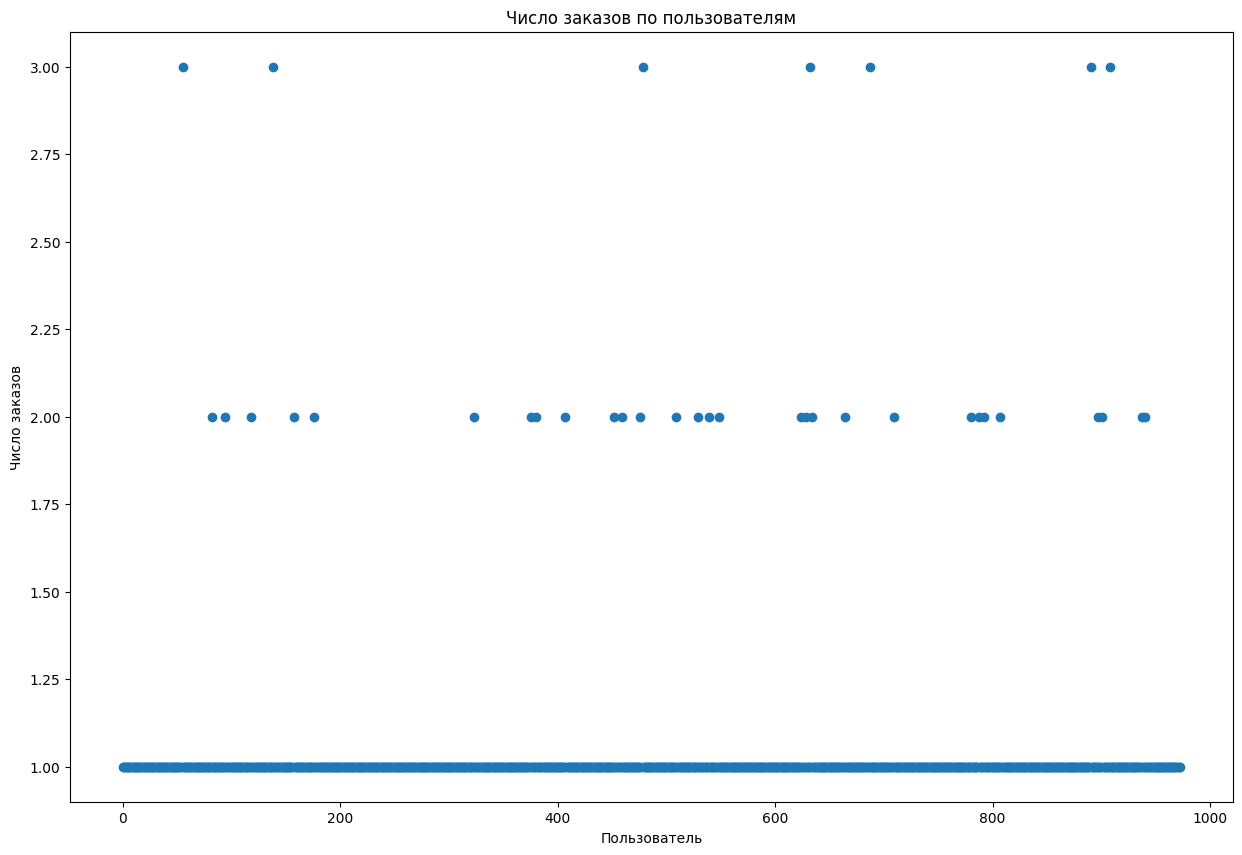

In [23]:
plt.figure(figsize=(15,10))
plt.scatter(a, new_df['orders'])
plt.xlabel('Пользователь')
plt.ylabel('Число заказов')
plt.title('Число заказов по пользователям')
plt.show()

Based on the obtained graph, we can conclude that, on average, there is one order per user, and no one made more than three orders.

### Conclusion
During this lab work, we prepared the collected data for analysis, removed missing values and duplicates, corrected data types and column names, and ensured that there was no information about overlapping users in the data.
In the first part of the work, we obtained cumulative aggregated data on visitors and orders by day from the collected data and constructed a graph of the number of orders by users.